<a href="https://colab.research.google.com/github/samratkar/samratkar.github.io/blob/main/_posts/concepts/genai/notes-codes/diffusion/code/Diffusion_Sanskrit_Gen_img.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Step 1: Define training model configuration

In [ ]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 32  # assumes images are square
    train_batch_size = 32
    eval_batch_size = 32
    num_epochs = 3
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 1
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "output"  # the model name
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0
    dataset_name="data128"

config = TrainingConfig()

### Step 2: Create Local Dataset Class and helper functions

In [2]:
%pip install -qq diffusers datasets accelerate wandb open-clip-torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDIMScheduler, DDPMPipeline
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm

In [ ]:
from datasets import Dataset
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import torchvision.transforms as T
import torch.nn.functional as F
from diffusers import UNet2DModel, DDPMScheduler, DPMSolverMultistepScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import DDPMPipeline
from accelerate import Accelerator
import torch
from tqdm.auto import tqdm
import os

def normalize_neg_one_to_one(img):
    return img * 2 - 1

# UPDATED LocalDataset class
class LocalDataset(Dataset):
    def __init__(self, folder, image_size, exts=['png']):
        super().__init__()
        self.folder = folder
        self.image_size = image_size

        # Match extensions case-insensitively
        self.paths = []
        for ext in exts:
            self.paths.extend([
                p for p in Path(folder).rglob(f'*.{ext}')
                if p.suffix.lower() == f'.{ext.lower()}'
            ])

        assert len(self.paths) > 0, f"No images found in {folder}. Check path and extensions."

        self.transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor(),
            T.Lambda(normalize_neg_one_to_one),
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = self.paths[index]
        img = Image.open(path).convert('L')  # Grayscale
        return self.transform(img)

def make_grid(images, rows, cols):
    # Helper function for making a grid of images
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def evaluate(config, epoch, pipeline):
    # Sample from the model and save the images in a grid
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.Generator(device='cpu').manual_seed(config.seed),
        num_inference_steps=50
    ).images

    image_grid = make_grid(images, rows=4, cols=4)

    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.


### Step 3: Define model training loop

In [ ]:
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs")
    )

    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)
                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        if accelerator.is_main_process:
            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=inference_scheduler)
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=inference_scheduler)
                save_dir = os.path.join(config.output_dir, f"epoch{epoch}")
                pipeline.save_pretrained(save_dir)

### Step 4: Load dataset

In [ ]:
!git clone https://github.com/samratkar/samratkar.github.io
data_folder = "./samratkar.github.io/_posts/concepts/genai/notes-codes/diffusion/dataset/data-devnagri/"


Cloning into 'samratkar.github.io'...
remote: Enumerating objects: 104621, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 104621 (delta 19), reused 19 (delta 9), pack-reused 104587 (from 3)
Receiving objects: 100% (104621/104621), 751.93 MiB | 38.60 MiB/s, done.
Resolving deltas: 100% (2452/2452), done.
Updating files: 100% (100709/100709), done.


In [ ]:
# Define data source
dataset = LocalDataset(data_folder, image_size=config.image_size)
train_dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

### Step 5: Define UNet Model

In [ ]:
# Define model
model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=1,  # the number of input channels
    out_channels=1,  # the number of output channels
    layers_per_block=1,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

### Step 6: Define optimizers and schedulers

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
# noise_scheduler = DDIMScheduler(num_train_timesteps=1000)
inference_scheduler = DPMSolverMultistepScheduler()
optimizer = AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

### Step 7: Run training on the model!

In [ ]:
from accelerate import notebook_launcher

args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)
notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


  0%|          | 0/2875 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/2875 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/2875 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/2875 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/2875 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/2875 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/2875 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/2875 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/2875 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/2875 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/2875 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/2875 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/2875 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/2875 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/2875 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/2875 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/2875 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/2875 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/2875 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/2875 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

### Step 8: Sample from trained diffusion model

Loads a pretrained DDPMPipeline from epoch99 of a local model directory (likely trained on glyphs or characters).

Moves the model to GPU.

Sets the scheduler to DPMSolverMultistepScheduler, which controls the denoising steps during sampling.

Generates 16 images in one batch.

Uses a fixed random seed (config.seed) for reproducibility.

Uses 50 diffusion steps to sample clean images from noise.

Arranges the 16 images into a 4x4 grid.

Creates a samples folder inside your config.output_dir.

Saves the resulting image grid as samples.png.

In [ ]:
model_path = "output/epoch2"  # Path to the specific epoch model directory# Path to the model directory
pipeline = DDPMPipeline.from_pretrained(model_path).to("cuda")
pipeline.scheduler = DPMSolverMultistepScheduler()

# Sample from the model and save the images in a grid
images = pipeline(
    batch_size=16,
    generator=torch.Generator(device='cuda').manual_seed(config.seed), # Generator can be on GPU here
    num_inference_steps=50
).images

# Make a grid out of the inverted images
image_grid = make_grid(images, rows=4, cols=4)

# Save the images
test_dir = os.path.join(config.output_dir, "samples")
os.makedirs(test_dir, exist_ok=True)
image_grid.save(f"{test_dir}/samples.png")

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

### Step 9: Visualize model generated images

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

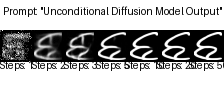

In [ ]:
from diffusers import DPMSolverMultistepScheduler, DDPMPipeline
from PIL import Image, ImageDraw, ImageFont
import torch

def make_labeled_grid(images, prompt, steps, font_path=None, font_size=20, margin=10):
    assert len(images) == len(steps), "The number of images must match the number of steps"

    w, h = images[0].size
    font = ImageFont.truetype(font_path, font_size) if font_path else ImageFont.load_default()

    # Calculate the height of the grid including the margin for text
    total_height = h + margin + font_size
    total_width = w * len(images)
    grid_height = total_height + margin + font_size  # Add extra margin for the prompt
    grid = Image.new('RGB', size=(total_width, grid_height), color=(255, 255, 255))
    # Draw the text prompt at the top
    draw = ImageDraw.Draw(grid)
    prompt_text = f"Prompt: \"{prompt}\""
    prompt_width, prompt_height = draw.textbbox((0, 0), prompt_text, font=font)[2:4]
    prompt_x = (total_width - prompt_width) / 2
    prompt_y = margin / 2
    draw.text((prompt_x, prompt_y), prompt_text, fill="black", font=font)

    for i, (image, step) in enumerate(zip(images, steps)):
        # Calculate position to paste the image
        x = i * w
        y = margin + font_size

        # Paste the image
        grid.paste(image, box=(x, y))

        # Draw the step text
        step_text = f"Steps: {step}"
        text_width, text_height = draw.textbbox((0, 0), step_text, font=font)[2:4]
        text_x = x + (w - text_width) / 2
        text_y = y + h + margin / 2 - 8
        draw.text((text_x, text_y), step_text, fill="black", font=font)
    return grid

# Initialize the model pipeline using your local model
model_path = "output/epoch2"  # Path to your trained model
pipeline = DDPMPipeline.from_pretrained(model_path).to("cuda")
pipeline.scheduler = DPMSolverMultistepScheduler()

# Define the number of steps to visualize
num_inference_steps_list = [1, 2, 3, 5, 10, 20, 50]

images = []

# Generate images for each value in num_inference_steps_list
for num_steps in num_inference_steps_list:
    generated_images = pipeline(
        batch_size=1,
        generator=torch.Generator(device='cuda').manual_seed(0),
        num_inference_steps=num_steps
    ).images
    images.append(generated_images[0])  # Append the generated image

# Create the labeled grid with a descriptive prompt since this is an unconditional model
prompt = "Unconditional Diffusion Model Output"
image_grid = make_labeled_grid(images, prompt, num_inference_steps_list)

# Show the grid
from IPython.display import display
display(image_grid)

# Save the image grid
image_grid.save("diffusion_steps_visualization3.png")

### Step 10: Create animated visualization

In [ ]:
from diffusers import DPMSolverMultistepScheduler, DDPMPipeline
from PIL import Image, ImageDraw, ImageFont
import torch
import numpy as np
import os
import imageio.v2 as imageio
from tqdm import tqdm

# Initialize the model pipeline using your local model
model_path = "output/epoch2"  # Path to your trained model
pipeline = DDPMPipeline.from_pretrained(model_path).to("cuda")
pipeline.scheduler = DPMSolverMultistepScheduler()

# Create output directory for frames
os.makedirs("animation_frames", exist_ok=True)

# Set parameters
num_inference_steps = 50
seed = 42

# Use the model's forward process to generate images at each step
print("Generating denoising frames...")

# Start with pure noise (t=1000)
generator = torch.Generator(device="cuda").manual_seed(seed)

# Store all frames
frames = []

# The correct way to visualize the denoising process is to use the pipeline with
# increasing numbers of denoising steps
for step in tqdm(range(0, num_inference_steps + 1, 2)):  # Skip some steps for faster generation
    if step == 0:
        # For the initial noise, just use the pipeline with 1 step
        # This will effectively show the noise
        current_step = 1
    else:
        current_step = step

    # Generate the image with the current number of denoising steps
    image = pipeline(
        batch_size=1,
        generator=torch.Generator(device="cuda").manual_seed(seed),
        num_inference_steps=current_step
    ).images[0]

    # Save the frame
    image.save(os.path.join("animation_frames", f"frame_{step:03d}.png"))
    frames.append(image)

# Create GIF from frames
print("Creating GIF animation...")
# Ensure all frames have the same size (shouldn't be necessary but just in case)
frames_resized = [frame.resize((256, 256)) for frame in frames]

# Save as GIF
output_gif = "diffusion_process3.gif"
frames_resized[0].save(
    output_gif,
    save_all=True,
    append_images=frames_resized[1:],
    optimize=False,
    duration=150,  # milliseconds per frame - slower to see the changes
    loop=0  # 0 means loop indefinitely
)

print(f"Animation saved to {output_gif}")

# Create a grid showing selected frames
def create_process_grid(frames, num_to_show=8):
    # Select frames evenly throughout the process
    if len(frames) <= num_to_show:
        selected_frames = frames
    else:
        indices = np.linspace(0, len(frames)-1, num_to_show, dtype=int)
        selected_frames = [frames[i] for i in indices]

    # Resize frames
    width, height = 256, 256
    selected_frames = [frame.resize((width, height)) for frame in selected_frames]

    # Create grid image
    cols = min(4, num_to_show)
    rows = (num_to_show + cols - 1) // cols

    grid = Image.new('RGB', (width * cols, height * rows))

    for i, frame in enumerate(selected_frames):
        row = i // cols
        col = i % cols
        grid.paste(frame, (col * width, row * height))

    return grid

# Create and save the grid
grid = create_process_grid(frames)
grid.save("diffusion_process_grid3.png")
print("Process grid saved to diffusion_process_grid3.png")

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

Generating denoising frames...




  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]



 12%|█▏        | 3/26 [00:00<00:01, 18.09it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]



 19%|█▉        | 5/26 [00:00<00:02, 10.10it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]



 27%|██▋       | 7/26 [00:00<00:02,  6.78it/s]

  0%|          | 0/14 [00:00<?, ?it/s]



 31%|███       | 8/26 [00:01<00:03,  5.73it/s]

  0%|          | 0/16 [00:00<?, ?it/s]



 35%|███▍      | 9/26 [00:01<00:03,  4.83it/s]

  0%|          | 0/18 [00:00<?, ?it/s]



 38%|███▊      | 10/26 [00:01<00:03,  4.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]



 42%|████▏     | 11/26 [00:02<00:04,  3.51it/s]

  0%|          | 0/22 [00:00<?, ?it/s]



 46%|████▌     | 12/26 [00:02<00:04,  3.10it/s]

  0%|          | 0/24 [00:00<?, ?it/s]



 50%|█████     | 13/26 [00:03<00:04,  2.79it/s]

  0%|          | 0/26 [00:00<?, ?it/s]



 54%|█████▍    | 14/26 [00:03<00:04,  2.50it/s]

  0%|          | 0/28 [00:00<?, ?it/s]



 58%|█████▊    | 15/26 [00:04<00:04,  2.28it/s]

  0%|          | 0/30 [00:00<?, ?it/s]



 62%|██████▏   | 16/26 [00:04<00:04,  2.05it/s]

  0%|          | 0/32 [00:00<?, ?it/s]



 65%|██████▌   | 17/26 [00:05<00:04,  1.91it/s]

  0%|          | 0/34 [00:00<?, ?it/s]



 69%|██████▉   | 18/26 [00:05<00:04,  1.78it/s]

  0%|          | 0/36 [00:00<?, ?it/s]



 73%|███████▎  | 19/26 [00:06<00:04,  1.66it/s]

  0%|          | 0/38 [00:00<?, ?it/s]



 77%|███████▋  | 20/26 [00:07<00:03,  1.57it/s]

  0%|          | 0/40 [00:00<?, ?it/s]



 81%|████████  | 21/26 [00:08<00:03,  1.47it/s]

  0%|          | 0/42 [00:00<?, ?it/s]



 85%|████████▍ | 22/26 [00:08<00:02,  1.39it/s]

  0%|          | 0/44 [00:00<?, ?it/s]



 88%|████████▊ | 23/26 [00:09<00:02,  1.33it/s]

  0%|          | 0/46 [00:00<?, ?it/s]



 92%|█████████▏| 24/26 [00:10<00:01,  1.27it/s]

  0%|          | 0/48 [00:00<?, ?it/s]



 96%|█████████▌| 25/26 [00:11<00:00,  1.21it/s]

  0%|          | 0/50 [00:00<?, ?it/s]



100%|██████████| 26/26 [00:12<00:00,  2.07it/s]

Creating GIF animation...
Animation saved to diffusion_process3.gif
Process grid saved to diffusion_process_grid3.png
